In [47]:
import pandas as pd
import numpy as np
import urllib.request
import json

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet

from prophet.plot import add_changepoints_to_plot


In [2]:
url = 'https://datosabiertos.bogota.gov.co/api/3/action/datastore_search?resource_id=c3867459-1aa7-4e16-8ae8-ca41693f7261'  

In [3]:
with urllib.request.urlopen(url) as response:
    data = json.loads(response.read().decode())

In [4]:
df = pd.DataFrame(data['result']['records'])

In [5]:
df.rename(columns={'Ano':'year', 'Temperatura Maxima':'maximum_temperature', 'Temperatura Minima':'minimum_temperature', 'Temperatura promedio':'average_temperature', 'Enos':'enos', 'Mes':'month'}, inplace = True)
df.head()


,year,maximum_temperature,minimum_temperature,average_temperature,enos,month,_id
0,2007,"26,4","4,4","14,11",Niño,Enero,1
1,2007,"25,4","-4,6","13,48",Neutro,Febrero,2
2,2007,24,"5,1","14,23",Neutro,Marzo,3
3,2007,23,"6,6","14,75",Neutro,Abril,4
4,2007,"21,9","5,9","13,26",Neutro,Mayo,5


In [6]:
def text_cleaner(row):
    row = row.lower()
    row = row.replace('ñ', 'n')
    row = row.strip()
    return row

In [7]:
df['enos'] = df['enos'].apply(text_cleaner)

In [8]:
df['month'] = df['month'].apply(text_cleaner)

In [9]:
def get_mont_value(row):
    if row == 'enero':
        return '01'
    elif row == 'febrero':
        return '02'
    elif row == 'marzo':
        return '03'
    elif row == 'abril':
        return '04'
    elif row == 'mayo':
        return '05'
    elif row == 'junio':
        return '06'
    elif row == 'julio':
        return '07'
    elif row == 'agosto':
        return '08'
    elif row == 'septiembre':
        return '09'
    elif row == 'octubre':
        return '10'
    elif row == 'noviembre':
        return '11'
    elif row == 'diciembre':
        return '12'

In [10]:
df['month'] = df['month'].apply(get_mont_value)

In [11]:
df['year_month'] = df['year'].astype(str)+'-'+df['month'].astype(str)

In [12]:
df['year_month'] = pd.to_datetime(df['year_month'])

In [13]:
df.sort_values(by = 'year_month', ascending=False, inplace= True)

In [14]:
df['maximum_temperature'] = df['maximum_temperature'].str.replace(',','.').astype(float)
df['minimum_temperature'] = df['minimum_temperature'].str.replace(',','.').astype(float)
df['average_temperature'] = df['average_temperature'].str.replace(',','.').astype(float)

In [36]:
df['nino'] = df['enos'].apply(lambda x: 1 if x=='nino' else 0)
df['nina'] = df['enos'].apply(lambda x: 1 if x == 'nina' else 0)

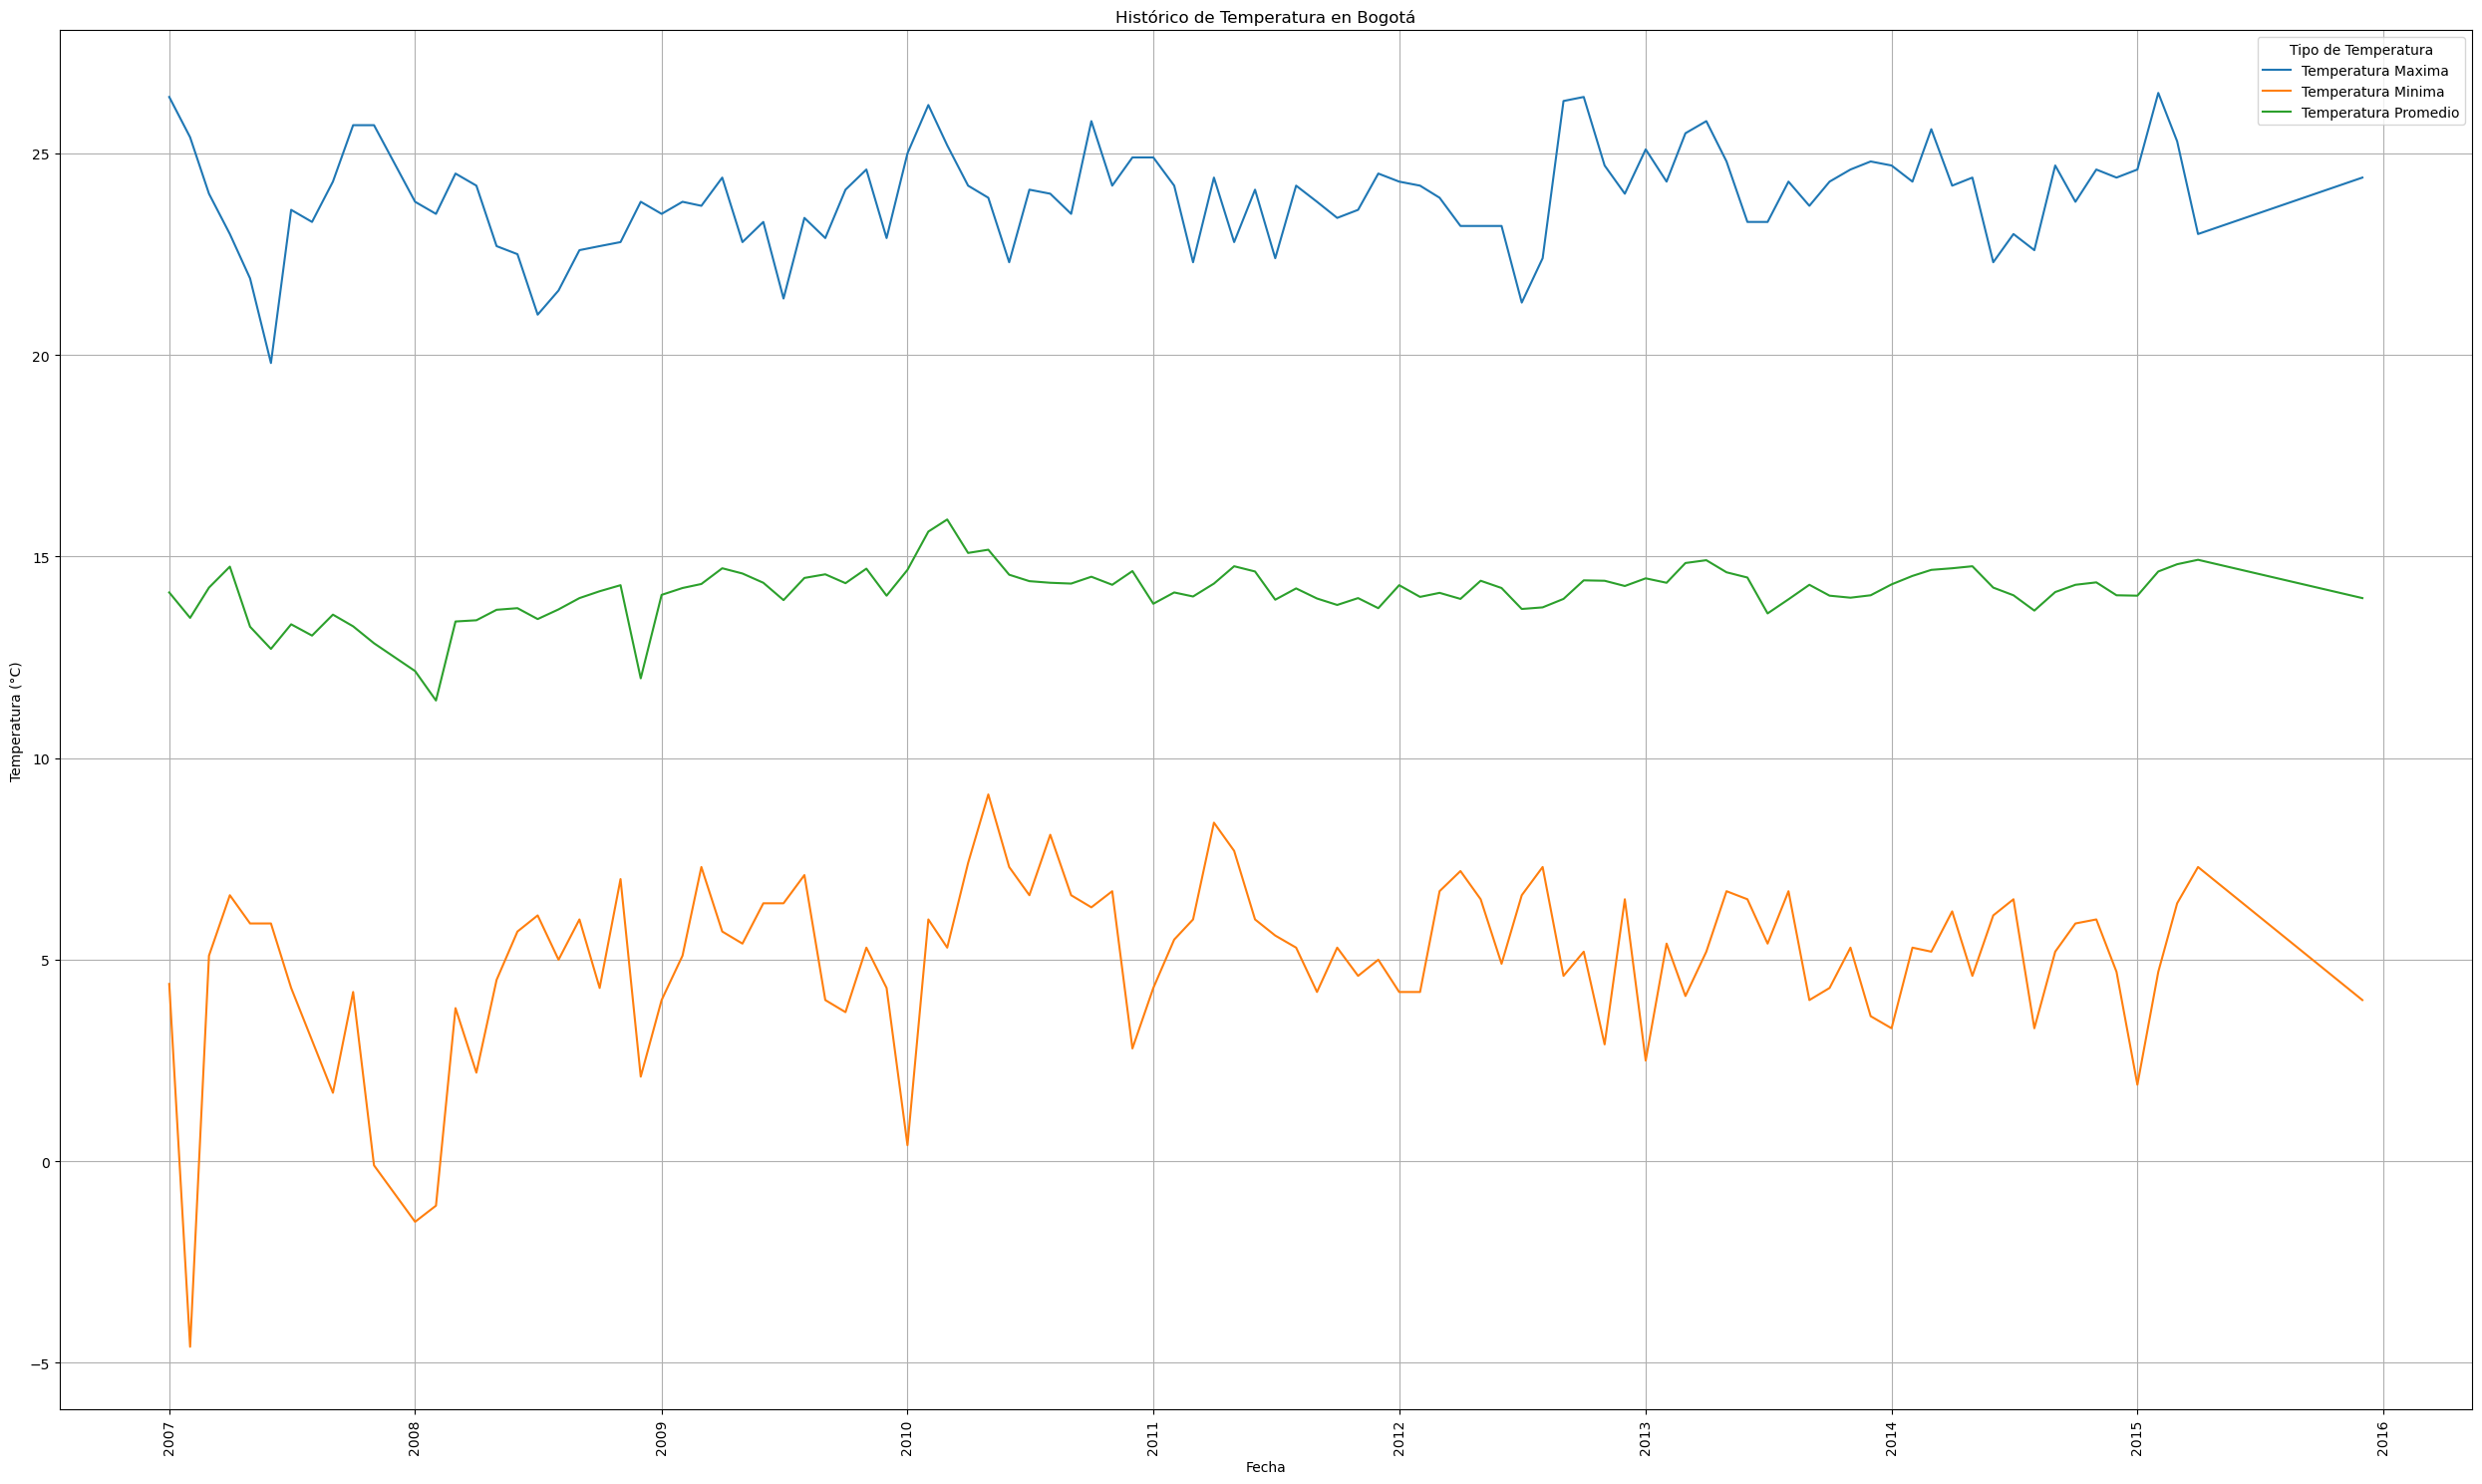

In [15]:

plt.figure(figsize=(25, 15))

# Utilizar data una sola vez y referenciar las columnas para x e y
sns.lineplot(data=df, x='year_month', y='maximum_temperature', label='Temperatura Maxima')
sns.lineplot(data=df, x='year_month', y='minimum_temperature', label='Temperatura Minima')
sns.lineplot(data=df, x='year_month', y='average_temperature', label='Temperatura Promedio')

plt.title('Histórico de Temperatura en Bogotá')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Tipo de Temperatura')
plt.tight_layout()

plt.show()


In [37]:
data_to_use = df[['year_month', 'average_temperature', 'maximum_temperature', 'minimum_temperature', 'nino', 'nina']]

In [38]:
data_to_use_copy = data_to_use.copy()

In [39]:
data_to_use_copy.rename(columns={'year_month':'ds', 'average_temperature':'y', 'maximum_temperature':'cap', 'minimum_temperature':'floor'}, inplace =True)

In [42]:
m = Prophet(growth='logistic')
m.add_regressor('nino')
m.add_regressor('nina')
m.fit(data_to_use_copy)


20:03:37 - cmdstanpy - INFO - Chain [1] start processing
20:03:37 - cmdstanpy - INFO - Chain [1] done processing


/opt/anaconda3/envs/weather_bogota/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/opt/anaconda3/envs/weather_bogota/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/weather_bogota/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


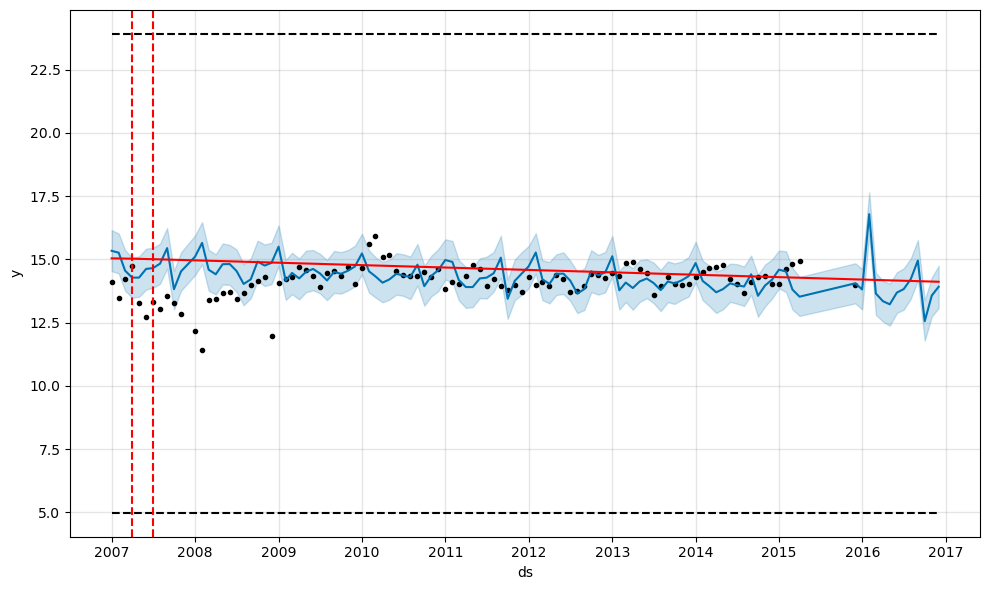

In [48]:
future = m.make_future_dataframe(periods=12, freq = 'M')
future['cap'] = data_to_use['maximum_temperature'].mean()
future['floor'] = data_to_use['minimum_temperature'].mean()
future['nino'] = 1
future['nina'] = 0
fcst = m.predict(future)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

/opt/anaconda3/envs/weather_bogota/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/weather_bogota/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/envs/weather_bogota/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

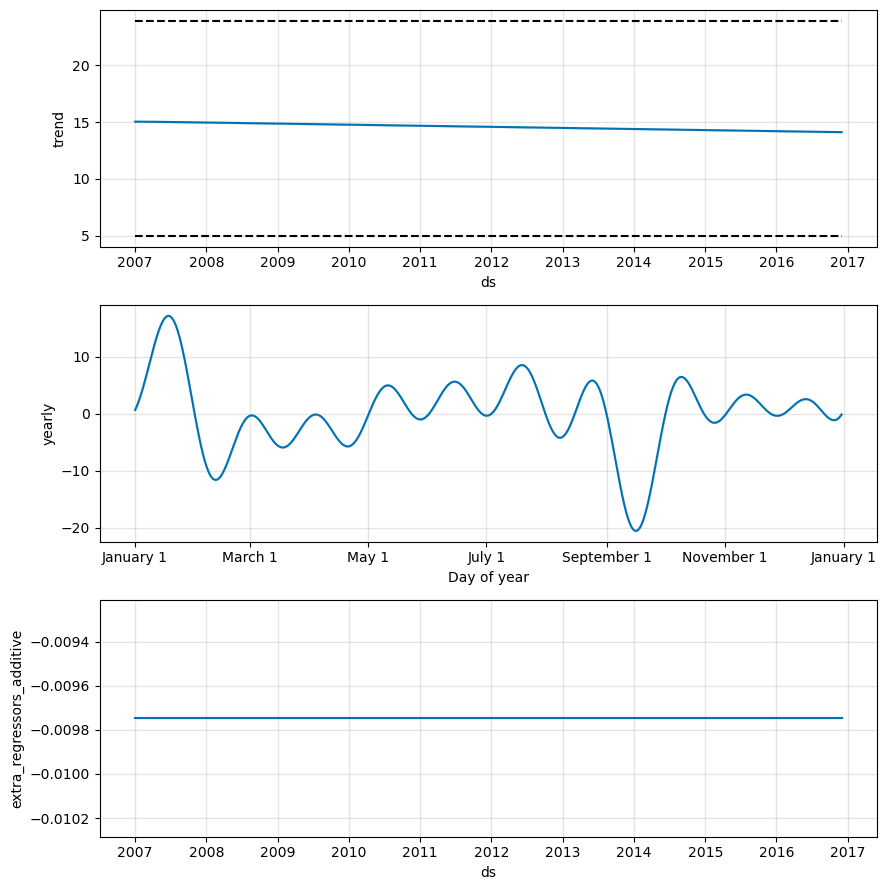

In [49]:
fig2 = m.plot_components(fcst)